In [2]:
# Import numerical python
import numpy as np
# Import pywake models including the IEA Wind Task 37 case study site, the Gaussian wake model and the AEP calculator
from py_wake.examples.data.iea37._iea37 import IEA37_WindTurbines, IEA37Site
from py_wake.deficit_models.gaussian import IEA37SimpleBastankhahGaussian
# Import Topfarm implementation of NREL Cost and Scaling model
from topfarm.cost_models.economic_models.turbine_cost import economic_evaluation as ee_1
# Import Topfarm constraints for site boundary and spacing
from topfarm.drivers.random_search_driver import RandomizeTurbinePosition_Circle, RandomizeAllUniform, RandomizeTurbinePosition, RandomizeAllRelativeMaxStep, RandomizeTurbinePosition_Normal,RandomizeTurbinePosition_Square, RandomizeNUniform 
from topfarm.constraint_components.boundary import CircleBoundaryConstraint, XYBoundaryConstraint
from topfarm.constraint_components.spacing import SpacingConstraint
# Import Topfarm support classes for setting up problem and workflow
from topfarm.cost_models.cost_model_wrappers import CostModelComponent, AEPCostModelComponent
from topfarm.cost_models.py_wake_wrapper import PyWakeAEPCostModelComponent
from topfarm import TopFarmGroup, TopFarmProblem
from topfarm.plotting import XYPlotComp, NoPlot
# Import Topfarm implementation of Random Search or Scipy drivers
from topfarm.easy_drivers import EasyRandomSearchDriver
from topfarm.easy_drivers import EasyScipyOptimizeDriver
from topfarm.easy_drivers import EasySimpleGADriver, EasyPyOptSparseSNOPT, EasyDriverBase

import topfarm
import pandas as pd
from Farm_Evaluator_Vec import *
import matplotlib.pyplot as plt
%matplotlib inline
from LSHADE import LSHADE
import seaborn as sns

In [3]:
coords = pd.read_csv('submission30.csv').values
new_coords = pd.read_csv('new_coords.csv').values
boundary_coords = np.array([[50,50],[3950,50],[3950,3950],[50,3950]])

In [4]:
power_curve  =  loadPowerCurve('Shell_Hackathon Dataset/power_curve.csv')
n_wind_instances, cos_dir, sin_dir, wind_sped_stacked, C_t = preProcessing(power_curve)
wind_inst_freq =  binWindResourceData('Shell_Hackathon Dataset/Wind Data/combined_data.csv')
turb_specs = {'Name': 'Anon Name','Vendor': 'Anon Vendor','Type': 'Anon Type','Dia (m)': 100,
              'Rotor Area (m2)': 7853,'Hub Height (m)': 100,'Cut-in Wind Speed (m/s)': 3.5,'Cut-out Wind Speed (m/s)': 25,
              'Rated Wind Speed (m/s)': 15,'Rated Power (MW)': 3}
def get_aep(x,y):
    turb_diam  =  turb_specs['Dia (m)']
    turb_rad   =  turb_diam/2 
    coords = np.vstack((x,y)).T
    AEP = getAEP(turb_rad, coords, power_curve, wind_inst_freq, 
                  n_wind_instances, cos_dir, sin_dir, wind_sped_stacked, C_t,0)  
    return AEP

In [113]:
coords = pd.read_csv('submission35.csv')
c = []
for i in range(50):
    x = coords['x'].str.split()[0][i].replace('[','')
    x = x.replace(']','')
    y = coords['y'].str.split()[0][i].replace('[','')
    y = y.replace(']','')
    c.append([float(x),float(y)])
c = np.array(c)

In [517]:
coords = pd.read_csv('submission54.csv').values
coords[coords<50]=50
coords[coords>3950]=3950
coord_dict = dict(zip('xy',coords.T))
def aep_func(x,y,**kwargs):
    aep = get_aep(x,y)
    print('{:.4f}'.format(aep))
    return -aep
n_wt = 50
aep_comp = CostModelComponent(input_keys=['x','y'], n_wt=n_wt, cost_function=aep_func,
                              output_key="aep", output_unit="GWh", objective=True)
problem = TopFarmProblem(
        design_vars=coord_dict,
        cost_comp=aep_comp,
        driver=EasyRandomSearchDriver(randomize_func=RandomizeTurbinePosition(max_step=0.1), max_iter=1000000),
        #driver=EasyScipyOptimizeDriver(optimizer='COBYLA', maxiter=1000, tol=1e-6, disp=False),
        #driver=EasyPyOptSparseSNOPT(),
        #driver=EasySimpleGADriver(max_gen=100, pop_size=100, Pm=0.5, Pc=.5, elitism=True, bits={'x':8,'y':8}),
        constraints=[SpacingConstraint(400),
                     XYBoundaryConstraint(boundary_coords)])

In [7]:
def reduce_score(state,max_step,max_iter):
    def aep_func(x,y,**kwargs):
        aep = get_aep(x,y)
        print('{:.4f}'.format(aep))
        return aep
    n_wt = 50
    aep_comp = CostModelComponent(input_keys=['x','y'], n_wt=n_wt, cost_function=aep_func,
                                  output_key="aep", output_unit="GWh", objective=True)
    problem = TopFarmProblem(
            design_vars=state,
            cost_comp=aep_comp,
            driver=EasyRandomSearchDriver(randomize_func=RandomizeTurbinePosition(max_step=max_step), max_iter=max_iter),
            constraints=[SpacingConstraint(400),
                         XYBoundaryConstraint(boundary_coords)])
    cost, state, recorder = problem.optimize()
    return state

In [6]:
def increase_score(state,max_step=None,max_iter=None,method='random_search'):
    def aep_func(x,y,**kwargs):
        aep = get_aep(x,y)
        print('{:.4f}'.format(aep))
        return -aep
    n_wt = 50
    aep_comp = CostModelComponent(input_keys=['x','y'], n_wt=n_wt, cost_function=aep_func,
                                  output_key="aep", output_unit="GWh", objective=True)
    if method=='random_search':
        problem = TopFarmProblem(
                design_vars=state,
                cost_comp=aep_comp,
                driver=EasyRandomSearchDriver(randomize_func=RandomizeTurbinePosition(max_step=max_step), max_iter=max_iter),
                constraints=[SpacingConstraint(400),
                             XYBoundaryConstraint(boundary_coords)])
    else:
        problem = TopFarmProblem(
                design_vars=state,
                cost_comp=aep_comp,
                driver=EasyScipyOptimizeDriver(optimizer='COBYLA', maxiter=1000, tol=1e-6, disp=False),
                constraints=[SpacingConstraint(400),
                             XYBoundaryConstraint(boundary_coords)])
    cost, state, recorder = problem.optimize()
    return state

In [49]:
coords = pd.read_csv('submission55.csv').values
coords[coords<50]=50
coords[coords>3950]=3950
coord_dict = dict(zip('xy',coords.T))

In [44]:
state = increase_score(coord_dict,100,1000000)

530.7933
530.7933
530.5723
530.7933
530.4706
530.7933
530.7356
530.7933
530.7933
530.7446
530.7933
530.0734
530.7933
530.6775
530.7933
530.7933
530.3821
530.7933
530.7929
530.7933
530.7933
530.7917
530.7933
530.6823
530.7933
530.1499
530.7933
530.3859
530.7933
530.1939
530.7933
530.3435
530.7933
530.7898
530.7933
530.7933
530.2953
530.7933
529.8699
530.7933
530.7933
530.2899
530.7933
530.0208
530.7933
530.4626
530.7933
530.7079
530.7933
530.6644
530.7933
530.7933
530.7933
530.7933
530.1240
530.7933
530.5155
530.7933
530.7933
530.6054
530.7933
530.7928
530.7933
530.7933
530.5266
530.7933
530.7933
530.6988
530.7933
530.6806
530.7933
530.7933
530.5303
530.7933
530.7609
530.7933
530.7933
530.5133
530.7933
530.7933
530.7933
530.1203
530.7933
530.7933
530.7933
530.5358
530.7933
530.7517
530.7933
530.5965
530.7933
530.5302
530.7933
530.3407
530.7933
530.2848
530.7933
530.7933
530.7933
530.3909
530.7933
530.7933
530.5551
530.7933
530.2496
530.7933
530.7933
530.5921
530.7933
530.7933
530.7933
5

530.4073
530.7933
530.4911
530.7933
530.3561
530.7933
530.7933
530.3355
530.7933
530.7933
530.7910
530.7933
529.8671
530.7933
530.7262
530.7933
530.7933
530.2524
530.7933
530.7933
530.7933
530.4295
530.7933
530.7933
530.6646
530.7933
530.5606
530.7933
530.1838
530.7933
530.7933
530.7933
530.5708
530.7933
530.5173
530.7933
530.7933
530.0118
530.7933
530.4648
530.7933
530.4606
530.7933
530.1428
530.7933
530.7933
530.4193
530.7933
530.3277
530.7933
530.7933
530.7294
530.7933
530.7166
530.7933
530.7933
530.7933
530.7933
530.3942
530.7933
530.7933
530.1339
530.7933
530.7366
530.7933
530.7793
530.7933
530.3370
530.7933
530.7933
530.4904
530.7933
530.7933
530.7933
530.7933
530.2427
530.7933
530.6146
530.7933
530.3784
530.7933
530.5538
530.7933
530.7366
530.7933
530.7933
530.4868
530.7933
530.5820
530.7933
530.7332
530.7933
530.7892
530.7933
530.7604
530.7933
530.4287
530.7933
530.7933
530.7933
530.3271
530.7933
530.7933
530.7281
530.7933
530.7933
530.1717
530.7933
530.7568
530.7933
530.6404
5

530.6487
530.7933
530.5149
530.7933
530.7933
530.4157
530.7933
530.7933
530.4035
530.7933
530.6356
530.7933
530.7933
530.7534
530.7933
530.6621
530.7933
530.2924
530.7933
530.4079
530.7933
530.7933
530.7933
530.7933
530.6784
530.7933
530.1952
530.7933
530.3290
530.7933
530.7933
530.7933
530.7310
530.7933
530.2177
530.7933
530.7933
530.7933
530.7933
530.0985
530.7933
530.5101
530.7933
530.7933
530.4320
530.7933
530.7931
530.7933
530.4282
530.7933
530.3824
530.7933
530.4705
530.7933
530.5268
530.7933
530.7635
530.7933
530.7745
530.7933
530.7933
530.5369
530.7933
530.7578
530.7933
530.7933
530.7933
530.7933
530.7898
530.7933
530.7933
530.2539
530.7933
530.7933
530.2580
530.7933
530.7933
530.4817
530.7933
530.6832
530.7933
530.1276
530.7933
530.6648
530.7933
530.7933
530.7231
530.7933
530.7933
530.7933
530.7928
530.7933
530.7553
530.7933
530.7928
530.7933
530.3557
530.7933
530.3320
530.7933
530.7933
530.0497
530.7933
530.7933
530.1343
530.7933
530.0411
530.7933
530.2904
530.7933
530.6708
5

530.7933
530.6764
530.7933
530.7577
530.7933
530.7356
530.7933
530.7933
530.7902
530.7933
530.7933
530.5510
530.7933
530.7933
530.7933
530.5477
530.7933
530.0903
530.7933
530.6888
530.7933
530.2440
530.7933
530.6525
530.7933
530.4498
530.7933
530.6499
530.7933
530.3355
530.7933
530.4715
530.7933
530.7923
530.7933
530.7933
530.7917
530.7933
530.7933
530.4161
530.7933
530.7933
530.7933
530.7933
530.7933
530.3122
530.7933
530.1801
530.7933
530.7933
530.7213
530.7933
530.4650
530.7933
530.7933
530.7933
530.5229
530.7933
530.4631
530.7933
530.0392
530.7933
530.7933
530.7933
530.3497
530.7933
530.3701
530.7933
530.7933
530.7818
530.7933
530.4384
530.7933
530.7933
530.7021
530.7933
530.7933
530.3576
530.7933
530.6641
530.7933
530.7933
530.7933
530.3205
530.7933
530.5258
530.7933
530.2196
530.7933
530.7471
530.7933
530.7933
530.1682
530.7933
530.7933
530.7933
530.7873
530.7933
530.7933
530.4514
530.7933
530.5500
530.7933
530.4269
530.7933
530.7781
530.7933
530.7933
530.5687
530.7933
530.5831
5

530.7933
530.6080
530.7933
530.7933
530.7791
530.7933
530.7933
529.8396
530.7933
530.5043
530.7933
530.7933
530.7165
530.7933
530.7933
530.5620
530.7933
530.7933
530.7307
530.7933
530.3150
530.7933
530.7933
530.7933
530.7933
530.4818
530.7933
530.7933
530.7933
530.4650
530.7933
530.2159
530.7933
530.7933
530.3099
530.7933
530.5035
530.7933
530.0585
530.7933
530.6409
530.7933
530.2540
530.7933
530.7933
529.8149
530.7933
530.2886
530.7933
530.3978
530.7933
530.7933
530.1440
530.7933
530.3662
530.7933
530.4569
530.7933
529.9192
530.7933
530.3926
530.7933
530.6773
530.7933
530.5066
530.7933
530.3137
530.7933
530.7933
530.0104
530.7933
530.4380
530.7933
530.0440
530.7933
530.7933
530.6560
530.7933
530.7933
530.1788
530.7933
530.1012
530.7933
530.7933
530.7933
530.7272
530.7933
530.7933
530.4473
530.7933
530.2283
530.7933
530.2954
530.7933
530.6341
530.7933
530.3515
530.7933
530.7933
530.2022
530.7933
530.6148
530.7933
530.7933
530.7933
530.7791
530.7933
530.7471
530.7933
530.7933
530.7933
5

530.7933
530.7933
530.7933
530.7422
530.7933
530.3630
530.7933
530.3580
530.7933
530.7344
530.7933
530.7933
530.5179
530.7933
530.2211
530.7933
530.4125
530.7933
530.6303
530.7933
530.3825
530.7933
530.4876
530.7933
529.8296
530.7933
530.4739
530.7933
530.5546
530.7933
530.7933
530.5501
530.7933
530.7933
530.7933
530.2443
530.7933
530.7933
530.4747
530.7933
530.5429
530.7933
530.3490
530.7933
530.7933
530.7933
530.2009
530.7933
530.7138
530.7933
530.0964
530.7933
530.7933
530.6470
530.7933
530.2515
530.7933
530.7933
530.7427
530.7933
530.7933
530.6088
530.7933
530.7933
530.7933
529.9253
530.7933
530.7409
530.7933
530.5705
530.7933
530.7933
530.7933
530.7933
530.6507
530.7933
530.6512
530.7933
530.4871
530.7933
530.4680
530.7933
530.5823
530.7933
530.7933
530.0230
530.7933
530.5274
530.7933
530.7933
530.2197
530.7933
530.7933
530.7933
530.1081
530.7933
530.4108
530.7933
530.2940
530.7933
530.6818
530.7933
530.7933
530.7933
530.7933
530.6433
530.7933
530.7933
530.3142
530.7933
530.5973
5

530.7933
530.3110
530.7933
530.1147
530.7933
530.7933
530.7933
530.7161
530.7933
530.7345
530.7933
530.2746
530.7933
530.1927
530.7933
530.7905
530.7933
530.7933
530.2019
530.7933
530.7933
530.2452
530.7933
530.3340
530.7933
530.7933
530.5893
530.7933
530.5125
530.7933
530.7441
530.7933
530.4456
530.7933
530.7933
530.4228
530.7933
530.0422
530.7933
530.1016
530.7933
530.7933
530.3287
530.7933
530.0230
530.7933
530.5262
530.7933
530.7906
530.7933
530.1565
530.7933
530.4292
530.7933
530.4462
530.7933
530.6288
530.7933
530.3335
530.7933
530.7382
530.7933
530.6016
530.7933
530.7051
530.7933
530.5262
530.7933
530.2254
530.7933
530.7933
530.6534
530.7933
530.2761
530.7933
530.4756
530.7933
530.1605
530.7933
530.1932
530.7933
530.7933
530.4358
530.7933
530.7892
530.7933
530.7933
530.7933
530.7933
530.0295
530.7933
530.7933
530.7933
530.7293
530.7933
530.3752
530.7933
530.6038
530.7933
530.4535
530.7933
530.3667
530.7933
530.6636
530.7933
530.2241
530.7933
530.3848
530.7933
530.7933
530.7182
5

530.7933
530.7933
530.6524
530.7933
530.4580
530.7933
530.7933
530.7373
530.7933
530.7933
530.7917
530.7933
530.7933
530.4137
530.7933
530.4644
530.7933
530.6644
530.7933
530.7933
530.4677
530.7933
530.7933
530.4596
530.7933
530.7933
530.1860
530.7933
530.7933
530.6538
530.7933
530.7933
530.5843
530.7933
530.4900
530.7933
530.7933
530.7933
530.1978
530.7933
530.2891
530.7933
530.4049
530.7933
530.5298
530.7933
530.5890
530.7933
530.7933
530.6089
530.7933
530.7933
530.6641
530.7933
530.0465
530.7933
530.7933
530.5816
530.7933
530.3243
530.7933
530.4763
530.7933
530.6915
530.7933
530.7933
530.6432
530.7933
530.7933
530.7933
530.7933
530.7933
530.4305
530.7933
530.7899
530.7933
530.7596
530.7933
530.3220
530.7933
530.1226
530.7933
530.7917
530.7933
530.4534
530.7933
530.7933
530.6205
530.7933
530.4081
530.7933
530.2876
530.7933
530.7933
530.5347
530.7933
530.3841
530.7933
530.2065
530.7933
530.7933
530.4524
530.7933
530.6002
530.7933
530.0386
530.7933
530.7933
530.5443
530.7933
530.1271
5

530.3832
530.7933
530.2741
530.7933
530.7933
530.3770
530.7933
530.3489
530.7933
530.0384
530.7933
530.6134
530.7933
530.6644
530.7933
530.3790
530.7933
530.7933
530.3446
530.7933
530.5262
530.7933
530.7933
530.5107
530.7933
530.7933
530.7494
530.7933
530.7227
530.7933
530.7915
530.7933
530.7933
530.7933
530.7823
530.7933
530.7933
530.5523
530.7933
530.2358
530.7933
530.6721
530.7933
530.6535
530.7933
530.3424
530.7933
530.7933
530.4962
530.7933
530.5017
530.7933
530.7933
530.7933
530.7933
530.4680
530.7933
530.7933
530.3424
530.7933
530.7933
530.2897
530.7933
530.7933
530.6074
530.7933
530.2050
530.7933
530.7087
530.7933
530.5281
530.7933
530.2966
530.7933
530.1758
530.7933
530.6450
530.7933
530.5017
530.7933
530.6080
530.7933
530.3905
530.7933
530.0961
530.7933
530.5155
530.7933
530.4898
530.7933
530.5812
530.7933
530.5410
530.7933
530.7933
530.6148
530.7933
530.6487
530.7933
530.3573
530.7933
530.7933
530.1931
530.7933
530.2493
530.7933
530.7933
530.7933
530.6975
530.7933
530.7933
5

530.7933
530.6780
530.7933
530.6073
530.7933
530.7933
530.5916
530.7933
530.7933
530.2598
530.7933
530.7933
530.7933
530.7933
530.7904
530.7933
530.5141
530.7933
530.3842
530.7933
530.7900
530.7933
530.7933
530.7933
530.3836
530.7933
530.7933
530.5067
530.7933
530.2334
530.7933
530.7933
530.7933
530.3705
530.7933
530.6018
530.7933
530.1946
530.7933
530.7933
530.3499
530.7933
530.6084
530.7933
530.3515
530.7933
530.2982
530.7933
530.7784
530.7933
530.6739
530.7933
530.2511
530.7933
530.6517
530.7933
530.3259
530.7933
530.7933
530.5028
530.7933
530.7933
530.2250
530.7933
530.7933
530.7933
530.7933
530.0755
530.7933
530.7933
530.3223
530.7933
530.7933
530.7933
530.7297
530.7933
530.5962
530.7933
530.7933
530.7933
530.7933
530.3746
530.7933
530.6846
530.7933
530.3968
530.7933
530.5455
530.7933
530.7298
530.7933
530.4027
530.7933
530.1738
530.7933
530.2947
530.7933
530.7227
530.7933
530.7933
530.7933
530.7933
530.7933
530.6328
530.7933
530.0950
530.7933
530.7933
530.7933
530.7535
530.7933
5

530.7933
530.7417
530.7933
530.3201
530.7933
530.7933
530.7933
530.6311
530.7933
530.3838
530.7933
530.7933
530.7268
530.7933
530.7933
530.7933
530.7933
530.7933
530.7923
530.7933
530.3725
530.7933
530.2919
530.7933
530.5091
530.7933
530.7933
530.2074
530.7933
530.2932
530.7933
530.7933
530.2088
530.7933
530.5617
530.7933
530.7933
530.7933
530.3863
530.7933
530.4723
530.7933
530.5016
530.7933
530.7933
530.3397
530.7933
530.7933
530.7933
530.4477
530.7933
530.0628
530.7933
530.5328
530.7933
530.1828
530.7933
530.5314
530.7933
529.8515
530.7933
530.6597
530.7933
530.6101
530.7933
530.7933
530.6565
530.7933
530.7933
530.6134
530.7933
530.0138
530.7933
530.4470
530.7933
530.2920
530.7933
530.7933
530.4363
530.7933
530.7933
530.3836
530.7933
530.3538
530.7933
530.5417
530.7933
530.7933
530.4261
530.7933
530.0853
530.7933
530.7933
530.6376
530.7933
530.2867
530.7933
530.7933
530.7933
530.4754
530.7933
530.4502
530.7933
530.2878
530.7933
530.4782
530.7933
530.7933
529.9827
530.7933
530.4372
5

In [59]:
state = increase_score(state,10,10000000)

530.6277
530.6265
530.6277
530.6260
530.6277
530.6277
530.5454
530.6277
530.2204
530.6277
530.6256
530.6277
530.6277
530.5540
530.6277
530.4194
530.6277
530.2127
530.6277
530.6277
530.5040
530.6277
530.4831
530.6277
530.5785
530.6277
530.4049
530.6277
530.6248
530.6277
530.4270
530.6277
530.6277
530.2765
530.6277
530.6272
530.6277
530.4633
530.6277
530.6244
530.6277
530.6200
530.6277
530.6272
530.6277
530.6245
530.6277
530.6253
530.6277
530.4874
530.6277
530.4829
530.6277
530.2779
530.6277
530.6259
530.6277
530.6254
530.6277
530.0737
530.6277
530.3850
530.6277
530.4713
530.6277
530.6272
530.6277
530.6229
530.6277
530.5811
530.6277
530.4954
530.6277
530.5617
530.6277
530.6227
530.6277
530.6216
530.6277
530.3820
530.6277
530.6007
530.6277
530.6272
530.6277
530.4633
530.6277
530.6246
530.6277
530.5929
530.6277
530.5563
530.6277
530.6277
530.6277
530.6277
530.5202
530.6277
530.5879
530.6277
530.2324
530.6277
530.2847
530.6277
530.6277
530.2373
530.6277
530.4637
530.6277
530.4477
530.6277
5

530.6277
530.6229
530.6277
530.6070
530.6277
530.4185
530.6277
530.3524
530.6277
530.5778
530.6277
530.4194
530.6277
530.6277
530.6229
530.6277
530.6207
530.6277
530.6253
530.6277
530.5891
530.6277
530.6277
530.4054
530.6277
530.5264
530.6277
530.6239
530.6277
530.6277
530.6243
530.6277
530.6267
530.6277
530.2921
530.6277
530.6265
530.6277
530.6249
530.6277
530.6256
530.6277
530.4263
530.6277
530.4259
530.6277
530.6277
530.6222
530.6277
530.2606
530.6277
530.6195
530.6277
530.4507
530.6277
530.6236
530.6277
530.6228
530.6277
530.6270
530.6277
530.6093
530.6277
530.3834
530.6277
530.0637
530.6277
530.6277
530.6277
530.3528
530.6277
530.6258
530.6277
530.4807
530.6277
530.4780
530.6277
530.5380
530.6277
530.4795
530.6277
530.3508
530.6277
530.6244
530.6277
530.3854
530.6277
530.6214
530.6277
530.4263
530.6277
530.5882
530.6277
530.5908
530.6277
530.2204
530.6277
530.6241
530.6277
530.6262
530.6277
530.5433
530.6277
530.6277
530.6277
530.2597
530.6277
530.2303
530.6277
530.6173
530.6277
5

530.6257
530.6277
530.6175
530.6277
530.5096
530.6277
530.6277
530.5800
530.6277
530.4564
530.6277
530.1440
530.6277
530.6254
530.6277
530.5467
530.6277
530.4752
530.6277
530.6077
530.6277
530.5923
530.6277
530.6231
530.6277
530.5938
530.6277
530.6233
530.6277
530.6277
530.6221
530.6277
530.2506
530.6277
530.1951
530.6277
530.6277
530.4639
530.6277
530.4225
530.6277
530.5857
530.6277
530.2468
530.6277
530.4949
530.6277
530.5693
530.6277
530.6206
530.6277
530.6229
530.6277
530.6272
530.6277
530.6161
530.6277
530.6277
530.6251
530.6277
530.5299
530.6277
530.4415
530.6277
530.5299
530.6277
530.3215
530.6277
530.5561
530.6277
530.3665
530.6277
530.6205
530.6277
530.4065
530.6277
530.4219
530.6277
530.6277
530.3673
530.6277
530.6257
530.6277
530.3817
530.6277
530.4952
530.6277
530.6275
530.6277
530.6277
530.5716
530.6277
530.4151
530.6277
530.5836
530.6277
530.4248
530.6277
530.4703
530.6277
530.3813
530.6277
530.3632
530.6277
530.6256
530.6277
530.6277
530.6154
530.6277
530.6245
530.6277
5

530.6140
530.6277
530.6256
530.6277
530.4358
530.6277
530.6277
530.2905
530.6277
530.4690
530.6277
530.5766
530.6277
530.6242
530.6277
530.6254
530.6277
530.3061
530.6277
530.6277
530.6277
530.6277
530.6093
530.6277
530.6277
530.5595
530.6277
530.2232
530.6277
530.5939
530.6277
530.6277
530.6277
530.5836
530.6277
530.5164
530.6277
530.5294
530.6277
530.3831
530.6277
530.5689
530.6277
530.3537
530.6277
530.5580
530.6277
530.6277
530.4280
530.6277
530.5709
530.6277
530.4774
530.6277
530.4537
530.6277
530.6277
530.4230
530.6277
530.1159
530.6277
530.6227
530.6277
530.5732
530.6277
530.4083
530.6277
530.5161
530.6277
530.4228
530.6277
530.6231
530.6277
530.6206
530.6277
530.3904
530.6277
530.5803
530.6277
530.6277
530.6237
530.6277
530.4769
530.6277
530.2791
530.6277
530.6265
530.6277
530.6277
530.6072
530.6277
530.3989
530.6277
530.2904
530.6277
530.6272
530.6277
530.2386
530.6277
530.4285
530.6277
530.6078
530.6277
530.6277
530.5120
530.6277
530.5336
530.6277
530.1435
530.6277
530.4981
5

530.4731
530.6278
530.3924
530.6278
530.6237
530.6278
530.3924
530.6278
530.5588
530.6278
530.5807
530.6278
530.6093
530.6278
530.4637
530.6278
530.4964
530.6278
530.6273
530.6278
530.3456
530.6278
530.2816
530.6278
530.3185
530.6278
530.5881
530.6278
530.4768
530.6278
530.6244
530.6278
530.6220
530.6278
530.5999
530.6278
530.1466
530.6278
530.2401
530.6278
530.4166
530.6278
530.3941
530.6278
530.5629
530.6278
530.5671
530.6278
530.2965
530.6278
530.5792
530.6278
530.5358
530.6278
530.1740
530.6278
530.5962
530.6278
530.6249
530.6278
530.6246
530.6278
530.6278
530.5909
530.6278
530.6263
530.6278
530.3820
530.6278
530.5107
530.6278
530.6245
530.6278
530.4636
530.6278
530.6072
530.6278
530.6249
530.6278
530.4861
530.6278
530.3385
530.6278
530.2193
530.6278
530.5852
530.6278
530.6231
530.6278
530.5664
530.6278
530.5731
530.6278
530.6034
530.6278
530.6275
530.6278
530.6263
530.6278
530.5673
530.6278
530.2411
530.6278
530.6252
530.6278
530.6169
530.6278
530.6251
530.6278
530.6278
530.6221
5

530.5194
530.6278
530.5580
530.6278
530.4051
530.6278
530.3630
530.6278
530.4931
530.6278
530.6272
530.6278
530.2315
530.6278
530.6261
530.6278
530.5994
530.6278
530.6265
530.6278
530.4871
530.6278
530.0699
530.6278
530.4366
530.6278
530.6083
530.6278
530.6269
530.6278
530.3882
530.6278
530.4302
530.6278
530.2767
530.6278
530.6265
530.6278
530.5783
530.6278
530.6233
530.6278
530.6278
530.5766
530.6278
530.6082
530.6278
530.3303
530.6278
530.5525
530.6278
530.6278
530.4995
530.6278
530.6278
530.6257
530.6278
530.6196
530.6278
530.5732
530.6278
530.4200
530.6278
530.2840
530.6278
530.5565
530.6278
530.4365
530.6278
530.5756
530.6278
530.6278
530.6272
530.6278
530.6244
530.6278
530.5836
530.6278
530.3657
530.6278
530.5882
530.6278
530.6212
530.6278
530.1508
530.6278
530.0856
530.6278
530.6028
530.6278
530.6278
530.4246
530.6278
530.6243
530.6278
530.6249
530.6278
530.0923
530.6278
530.4444
530.6278
530.6278
530.6253
530.6278
530.4792
530.6278
530.5593
530.6278
530.6265
530.6278
530.6278
5

530.6278
530.5533
530.6278
530.6207
530.6278
530.4513
530.6278
530.2462
530.6278
530.2935
530.6278
530.5886
530.6278
530.6219
530.6278
530.5517
530.6278
530.6248
530.6278
530.6215
530.6278
530.6255
530.6278
530.4482
530.6278
530.6278
530.3571
530.6278
530.4972
530.6278
530.6273
530.6278
530.4614
530.6278
530.6027
530.6278
530.6246
530.6278
530.4190
530.6278
530.6169
530.6278
530.5264
530.6278
530.2694
530.6278
530.6105
530.6278
530.6196
530.6278
530.4836
530.6278
530.6278
530.6222
530.6278
530.6272
530.6278
530.6229
530.6278
530.5681
530.6278
530.2226
530.6278
530.4203
530.6278
530.5880
530.6278
530.6277
530.6278
530.5775
530.6278
530.4220
530.6278
530.0737
530.6278
530.6257
530.6278
530.6211
530.6278
530.6182
530.6278
530.6237
530.6278
530.6278
530.4989
530.6278
530.5562
530.6278
530.5657
530.6278
530.6007
530.6278
530.6278
530.6274
530.6278
530.3824
530.6278
530.5922
530.6278
530.5868
530.6278
530.2614
530.6278
530.6089
530.6278
530.5720
530.6278
530.4733
530.6278
530.6231
530.6278
5

530.6278
530.6278
530.4642
530.6278
530.2763
530.6278
530.2713
530.6278
530.5965
530.6278
530.3984
530.6278
530.2692
530.6278
530.6223
530.6278
530.4547
530.6278
530.2764
530.6278
530.4402
530.6278
530.2909
530.6278
530.5474
530.6278
530.5566
530.6278
530.4816
530.6278
530.4324
530.6278
530.4878
530.6278
530.6256
530.6278
530.1709
530.6278
530.5101
530.6278
530.5097
530.6278
530.6249
530.6278
530.6270
530.6278
530.3320
530.6278
530.6218
530.6278
530.6264
530.6278
530.6061
530.6278
530.6259
530.6278
530.2401
530.6278
530.4090
530.6278
530.6239
530.6278
530.4539
530.6278
530.6278
530.1160
530.6278
530.1902
530.6278
530.5546
530.6278
530.6258
530.6278
530.6249
530.6278
530.1956
530.6278
530.6059
530.6278
530.6278
530.2741
530.6278
530.4770
530.6278
530.5590
530.6278
530.5808
530.6278
530.5854
530.6278
530.6245
530.6278
530.4160
530.6278
530.5104
530.6278
530.4335
530.6278
530.4049
530.6278
530.6158
530.6278
530.4948
530.6278
530.6278
530.5801
530.6278
530.5981
530.6278
530.5943
530.6278
5

530.6270
530.6278
530.6278
530.6260
530.6278
530.6262
530.6278
530.6278
530.4850
530.6278
530.6257
530.6278
530.6195
530.6278
530.5962
530.6278
530.6278
530.4550
530.6278
530.4195
530.6278
530.4209
530.6278
530.2614
530.6278
530.6278
530.6013
530.6278
530.6271
530.6278
530.4668
530.6278
530.5967
530.6278
530.2213
530.6278
530.6246
530.6278
530.5897
530.6278
530.6273
530.6278
530.5626
530.6278
530.5579
530.6278
530.6255
530.6278
530.6235
530.6278
530.6265
530.6278
530.4292
530.6278
530.5976
530.6278
530.6278
530.6161
530.6278
530.5525
530.6278
530.6176
530.6278
530.6278
530.4871
530.6278
530.6278
530.4182
530.6278
530.6021
530.6278
530.5545
530.6278
530.6278
530.6229
530.6278
530.1436
530.6278
530.6257
530.6278
530.6278
530.4592
530.6278
530.6163
530.6278
530.6080
530.6278
530.6272
530.6278
530.6278
530.5550
530.6278
530.2874
530.6278
530.6278
530.6278
530.6278
530.6196
530.6278
530.2430
530.6278
530.5958
530.6278
530.6256
530.6278
530.6158
530.6278
530.6254
530.6278
530.5880
530.6278
5

530.6278
530.6169
530.6278
530.6278
530.5994
530.6278
530.6244
530.6278
530.5114
530.6278
530.6196
530.6278
530.5897
530.6278
530.4522
530.6278
530.5566
530.6278
530.5198
530.6278
530.2805
530.6278
530.6273
530.6278
530.6278
530.3130
530.6278
530.6278
530.5732
530.6278
530.6232
530.6278
530.5815
530.6278
530.6278
530.6156
530.6278
530.6256
530.6278
530.6271
530.6278
530.4980
530.6278
530.5550
530.6278
530.5851
530.6278
530.6166
530.6278
530.5097
530.6278
530.5818
530.6278
530.4573
530.6278
530.4978
530.6278
530.2805
530.6278
530.4439
530.6278
530.6248
530.6278
530.1436
530.6278
530.4531
530.6278
530.3212
530.6278
530.6258
530.6278
530.6231
530.6278
530.6278
530.6265
530.6278
530.6207
530.6278
530.5701
530.6278
530.1496
530.6278
530.6278
530.5898
530.6278
530.6219
530.6278
530.6229
530.6278
530.6229
530.6278
530.6278
530.6235
530.6278
530.4345
530.6278
530.6278
530.2939
530.6278
530.6169
530.6278
530.6253
530.6278
530.6219
530.6278
530.3813
530.6278
530.3486
530.6278
530.6259
530.6278
5

530.6260
530.6278
530.6218
530.6278
530.2525
530.6278
530.6272
530.6278
530.5897
530.6278
530.5579
530.6278
530.5566
530.6278
530.6272
530.6278
530.4652
530.6278
530.4261
530.6278
530.6248
530.6278
530.6261
530.6278
530.5606
530.6278
530.6233
530.6278
530.6262
530.6278
530.4554
530.6278
530.6278
530.3830
530.6278
530.4458
530.6278
530.5626
530.6278
530.4770
530.6278
530.2953
530.6278
530.2192
530.6278
530.5380
530.6278
530.6278
530.6278
530.5193
530.6278
530.5518
530.6278
530.6265
530.6278
530.6277
530.6278
530.6269
530.6278
530.4248
530.6278
530.2770
530.6278
530.4005
530.6278
530.6021
530.6278
530.3115
530.6278
530.4427
530.6278
530.5658
530.6278
530.6278
530.2521
530.6278
530.3656
530.6278
530.2743
530.6278
530.3944
530.6278
530.5595
530.6278
530.4768
530.6278
530.6255
530.6278
530.6182
530.6278
530.5801
530.6278
530.2653
530.6278
530.6093
530.6278
530.3914
530.6278
530.6240
530.6278
530.4869
530.6278
530.6242
530.6278
530.2786
530.6278
530.5881
530.6278
530.6266
530.6278
530.4731
5

In [42]:
save_coords(state)

In [47]:
state = reduce_score(coord_dict,20,10)

530.7933
530.7914
530.7914
530.7914
530.5421
530.5421
530.3684
530.3684
530.3161
530.3161
530.3161
530.3142
530.3142
529.9788
529.9788
529.6333
529.6333
529.1077
529.1077
528.8503
528.8503


In [465]:
state['x'] = state['x'][0]
state['y'] = state['y'][0]
save_coords(state)

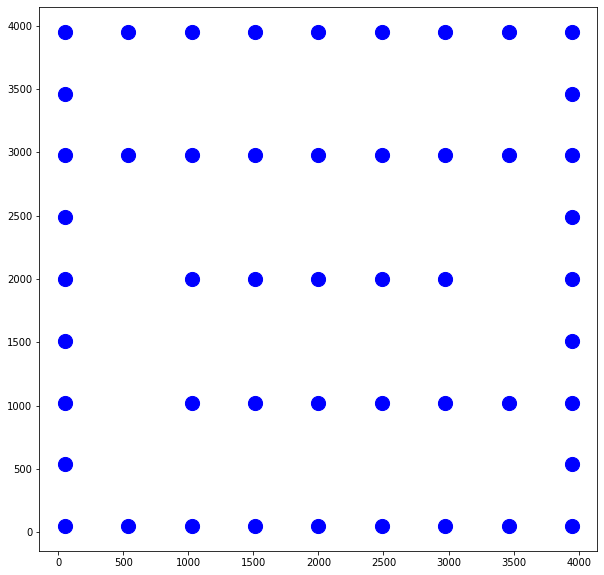

In [51]:
plot(coord_dict)

In [431]:
#Circular coords
co = []
center = [2000,2000]
r = 1950*1.414
delta_r = 400
start_theta = 0
while r>200:
    delta_theta = 2*np.arcsin(200/r)+0.02
    for theta in np.arange(start_theta,start_theta+2*np.pi-delta_theta,delta_theta):
        c = [center[0]+r*np.cos(theta),center[1]+r*np.sin(theta)]
        if c[0]>=50 and c[0]<=3950 and c[1]>=50 and c[1]<=3950:
            co.append(c)
    r = r - delta_r
    start_theta += delta_theta/2
co = np.array(co)

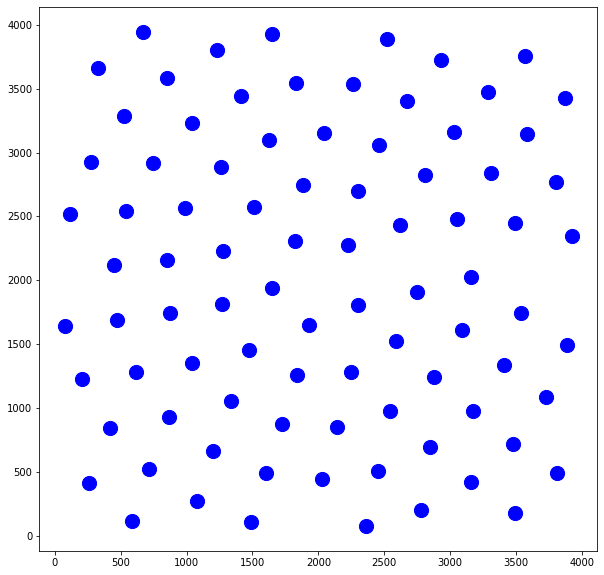

In [432]:
plot_turbines(co)

In [434]:
d = len(co)
turb = 50
n_max = 100000
Np = 300
f_coords = 0
np_min = 4
ls_ = LSHADE(Np,d,co,turb,n_max,np_min)
ls_.run()

504.7181
506.8257
506.8257
506.8257
506.8257
507.1141
507.1544
507.1544
507.1544
507.1544
508.0446
508.0446
508.0446
508.0574
508.0574
508.0574
508.0574
508.1266
508.1266
508.2791
508.2791
508.4211
508.4211
508.4211
508.5420
508.5420
508.7608
508.7608
508.7608
508.7608
508.7815
508.7815
509.0113
509.0113
509.4307
509.4855
509.4855
509.4855
509.4855
509.4855
509.4855
509.5476
509.5476
509.7480
509.7480
509.7480
509.7480
509.7480
509.7480
509.7480
509.7480
509.7480
509.7480
509.7480
509.7480
509.7480
509.7480
509.8035
509.8671
509.8891
509.8891
509.8891
509.8891
509.9496
510.0166
510.0166
510.0302
510.0800
510.0800
510.0800
510.0800
510.0801
510.1785
510.1785
510.1972
510.1972
510.1972
510.1972
510.1972
510.1972
510.1972
510.2182
510.2949
510.2949
510.3746
510.3746
510.3746
510.3746
510.3746
510.3746
510.3746
510.3746
510.3746
510.3746
510.3746
510.3746
510.3746
510.3746
510.3746
510.3746
510.3799
510.3799
510.3799
510.3937
510.3937
510.3937
510.4452
510.4452
510.4452
510.4452
510.4452
5

KeyboardInterrupt: 

In [365]:
state1['x'] = state1['x'][0]
state1['y'] = state1['y'][0]

In [312]:
get_objective(pd.read_csv('submission33.csv'))

530.7879501342774

In [307]:
sub = pd.DataFrame(state1,columns=['x','y'])

In [313]:
sub.to_csv('submission33.csv',index=False)

In [303]:
(np.array([1,2,3])>1).any()

True

In [345]:
coords[coords>3950] = 3950

In [346]:
coords = opt_sol
if (coords[:,0]<50).any() or (coords[:,1]<50).any() or (coords[:,0]>3950).any() or (coords[:,1]>3950).any():
    print('np')

In [353]:
class RandomSearch2:
    
    def __init__(self,opt_sol,n_turbs,max_step,min_step,max_iters,worst_turb=True):
        self.n_turbs = n_turbs
        self.max_step = max_step
        self.min_step = min_step
        self.max_iters = max_iters
        self.worst_turb = worst_turb
        self.opt_sol = opt_sol
        self.aeps = self.get_aeps()
        self.best_score = self.get_aep()
    
    def is_edge_point(self,turb,delta):
        """
        checks if a turbine location is on the edge. This could be used to constrain the angle.
        returns 0 -> bottom edge, 1 -> top edge, 2 -> left edge, 3 -> right edge, 4 -> left bottom corner and so on
        """
        coord = self.opt_sol[turb]
        if coord[0]-delta<50 and coord[1]-delta<50:
            return 5
        if coord[0]+delta>3950 and coord[1]-delta<50:
            return 6
        if coord[0]-delta<50 and coord[1]+delta>3950:
            return 7
        if coord[0]+delta>3950 and coord[1]+delta>3950:
            return 8
        if coord[0]-delta<50:
            return 3
        if coord[0]+delta>3950:
            return 4
        if coord[1]-delta<50:
            return 1
        if coord[1]+delta>3950:
            return 2
        else:
            return 0
    
    def get_aeps(self):
        return get_objective(self.opt_sol,get_each_turb_aep=1)
    
    def get_aep(self):
        return get_objective(self.opt_sol)
    
    def get_turbine_indices(self):
        if self.worst_turb:
            ind = np.argsort(self.aeps)[:self.n_turbs]
            return ind
        else:
            ind = np.random.choice(list(range(50)),size=self.n_turbs,replace=False)
            return ind
    
    def check_constraints(self,coords):
        if checkConstraints(coords,100)<0:
            return 0
        if (coords[:,0]<50).any() or (coords[:,1]<50).any() or (coords[:,0]>3950).any() or (coords[:,1]>3950).any():
            return 0
        return 1
    
    def get_angle_space(self,turb,delta):
        edge = self.is_edge_point(turb,delta)
        if edge==0:
            return np.linspace(0,2*np.pi,100,endpoint=False)
        if edge==1:
            return np.linspace(0,np.pi,100)
        if edge==2:
            return np.linspace(np.pi,2*np.pi,100)
        if edge==3:
            return np.linspace(-np.pi/2,np.pi/2,100)
        if edge==4:
            return np.linspace(np.pi/2,3*np.pi/2,100)
        if edge==5:
            return np.linspace(0,np.pi/2,100)
        if edge==6:
            return np.linspace(np.pi/2,np.pi,100)
        if edge==7:
            return np.linspace(-np.pi/2,0,100)
        if edge==8:
            return np.linspace(np.pi,3*np.pi/2,100)
    
    def make_move(self,coord,angle,delta):
        """
        returns a coordinate by making a move in the given direction.
        """
        new_x = coord[0] + delta*np.cos(angle)
        new_y = coord[1] + delta*np.sin(angle)
        return np.array([new_x,new_y])
    
    def run(self):
        for i in range(self.max_iters):
            indices = self.get_turbine_indices()
            temp_sol = self.opt_sol.copy()
            for turb in indices:
                delta = np.random.uniform(self.min_step,self.max_step)
                Theta = self.get_angle_space(turb,delta)
                theta = np.random.choice(Theta)
                temp = temp_sol.copy()
                temp[turb] = self.make_move(temp_sol[turb],theta,delta)
                if self.check_constraints(temp):
                    temp_sol = temp
            temp_score = get_objective(temp_sol)
            
            if temp_score>self.best_score:
                self.best_score = temp_score
                self.opt_sol = temp_sol
                print('Yes!!!!!!')
            print('{:.4f}'.format(temp_score))
            

In [361]:
opt_sol = pd.read_csv('submission33.csv').values
opt_sol[opt_sol>3950] = 3950
opt_sol[opt_sol<50] = 50
max_step = 1.01
min_step = 1
max_iters = 10000
n_turbs = 2
rs = RandomSearch2(opt_sol,n_turbs,max_step,min_step,max_iters,worst_turb=True)
rs.run()

530.7617
530.5911
530.6786
530.7719
530.4703
530.6786
530.6780
530.7717
530.5912
530.7723
530.5797
530.7719
530.6786
530.6786
530.7716
530.5337
530.6775
530.6797
530.6786
530.4973
530.5909
530.6524
530.6798
530.6786
530.5892
530.4977
530.7723
530.4991
530.5895
530.5912
530.7611
530.4974
530.5892
530.4973
530.7716
530.7613
530.7723
530.7723
530.7611
530.5909
530.6524
530.4826
530.5493
530.7717
530.6428
530.4974
530.6803
530.6803
530.7716
530.5909
530.7719
530.4704
530.5911
530.6428
530.7720
530.7723
530.7720
530.7611
530.6781
530.6786
530.6786
530.6411
530.5892
530.7699
530.6786
530.7723
530.6524
530.7611
530.6411
530.4974
530.5910
530.5911
530.7704
530.5494
530.6786
530.6428
530.6780
530.7714
530.6518
530.4974
530.7723
530.4704
530.4828
530.6780
530.7699
530.5912
530.7720
530.5493
530.5911
530.5892
530.4710
530.4818
530.7611
530.7720
530.6324
530.6780
530.4974
530.5890
530.6786
530.6429
530.6431
530.5910
530.7723
530.4974
530.6803
530.6428
530.7611
530.7704
530.4984
530.6519
530.6429
5

530.5912
530.4828
530.5892
530.7717
530.7720
530.5493
530.7723
530.7723
530.6428
530.7720
530.4973
530.7617
530.6316
530.5907
530.6431
530.4710
530.6781
530.6429
530.7720
530.6780
530.5892
530.7617
530.7723
530.5494
530.5910
530.5909
530.4990
530.6630
530.6634
530.7723
530.6428
530.4973
530.7723
530.4974
530.7714
530.5788
530.7617
530.6316
530.6798
530.7617
530.7720
530.6524
530.7617
530.5892
530.5511
530.6780
530.6431
530.6786
530.5223
530.6518
530.7698
530.6803
530.7717
530.6431
530.5890
530.4973
530.6412
530.6431
530.5910
530.7698
530.6781
530.6411
530.5797
530.4974
530.6786
530.6518
530.6780
530.6431
530.4974
530.6780
530.6411
530.6412
530.4826
530.6781
530.6524
530.7611
530.7720
530.6417
530.7723
530.6519
530.7720
530.6780
530.6411
530.7723
530.5510
530.4974
530.7613
530.7617
530.7704
530.6519
530.6780
530.5892
530.6786
530.6786
530.6634
530.4828
530.6780
530.4977
530.7719
530.5909
530.7699
530.4974
530.7704
530.7617
530.6524
530.7720
530.4816
530.6781
530.7723
530.5914
530.6803
5

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [41]:
def save_coords(coords,k=None):
    try:
        p = coords[0,0]
    except:
        coords = np.vstack((state['x'],state['y'])).T
    if k:
        sub = pd.DataFrame(coords,columns=['x','y'])
        sub.to_csv('submission'+str(k)+'.csv',index=False)
    else:
        import os
        max_k = 0
        for file in os.listdir():
            if file[:10]=='submission':
                k = float(file[10:12])
                max_k = max(k,max_k)
        sub = pd.DataFrame(coords,columns=['x','y'])
        sub.to_csv('submission'+str(int(max_k)+1)+'.csv',index=False)

In [205]:
c1=0.021
c2=42
c3=1.26
c4=1.05
c5=0.336
c6=0.42
c7=54
c8=19

In [214]:
best_y  = 100
for x in np.linspace(0,19,1000):
    y = c5*x**c6 - np.pi*c1*x*(x**c4*c2*c4*(2*c1**2*c7/(np.pi*c1*x))**c3/c7 + c5*c6*x**(c6-1)/(np.pi*c1)) + c2*c3*(2*c1**2*c7/(np.pi*c1*x))**(c3-2)/2 * c1**2
    if abs(y)<best_y:
        best_x = x
        best_y = abs(y)

In [251]:
save_coords(state)

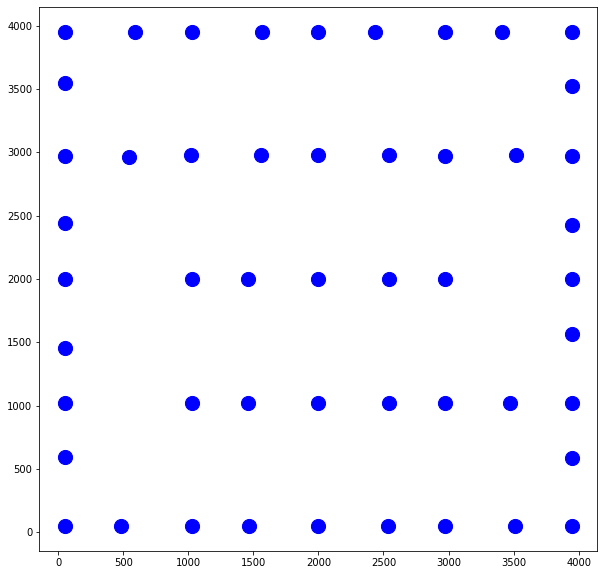

In [166]:
plot(state)

In [108]:
min(max_coords[:,0])

50.0

In [96]:
max_score = 530.7913
for j in range(100):
    score = get_aep(recorder.driver_iteration_dict['x'][j],recorder.driver_iteration_dict['y'][j])
    if score>max_score:
        max_score = score
        print(max_score)
        max_coords = np.vstack((recorder.driver_iteration_dict['x'][j],recorder.driver_iteration_dict['y'][j])).T

530.7879501342774
530.7890194702148
530.7907571411133
530.7913586425781


IndexError: list index out of range

In [250]:
state['x'] = state['x'][0]
state['y'] =state['y'][0]

In [98]:
sub = pd.DataFrame(max_coords,columns=['x','y'])
sub.to_csv('submission31.csv',index=False)

In [53]:
def get_objective(coords,get_each_turb_aep=0):
    try:
        return getAEP(50, coords, power_curve, wind_inst_freq, 
                      n_wind_instances, cos_dir, sin_dir, wind_sped_stacked, C_t,get_each_turb_aep)  
    except:
        coords = np.vstack((coords['x'],coords['y'])).T
        return getAEP(50, coords, power_curve, wind_inst_freq, 
                      n_wind_instances, cos_dir, sin_dir, wind_sped_stacked, C_t,get_each_turb_aep)  

In [18]:
def plot_turbines(coords):
    plt.figure(figsize=(10,10))
    plt.scatter(coords[:,0],coords[:,1],color='b',s=200)
    plt.show()
def plot(state):
    plot_turbines(np.vstack((state['x'],state['y'])).T)

In [60]:
coords = pd.read_csv('submission11.csv').values
k = coords.copy()
coords_ = []
for a in k:
    if a[0]==3950:
        if a[1]!=3950:
            t = (a[1]-50)//433.33
            a[1] -= t*33.33
    if a[1]==3950:
        t = (a[0]-50)//433.33
        a[0] -= t*33.33
    coords_.append([a[0],a[1]])
coords_ = np.array(coords_)
coords_ = np.vstack((coords_,[3950,3652]))

In [61]:
checkConstraints(coords_,100)

0

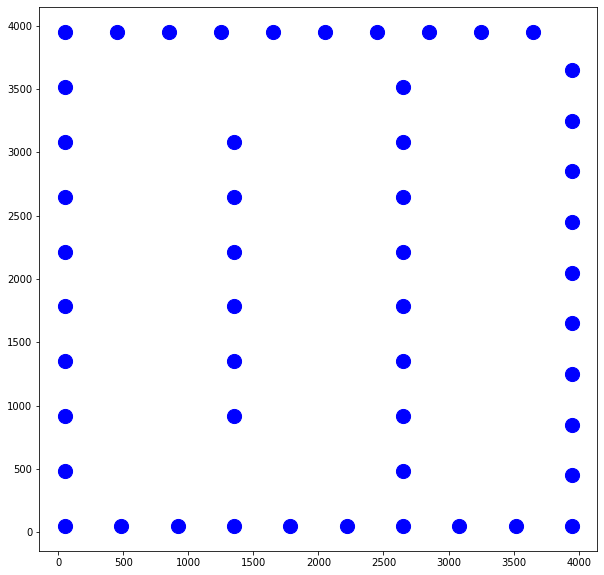

In [64]:
plot_turbines(coords_)

In [67]:
np.delete(coords_,0,axis=0).shape

(50, 2)

In [69]:
for i in range(51):
    coords__ = np.delete(coords_,i,axis=0)
    print(get_objective(coords))

525.9276846313477
525.9276846313477
525.9276846313477
525.9276846313477
525.9276846313477
525.9276846313477
525.9276846313477
525.9276846313477
525.9276846313477
525.9276846313477
525.9276846313477
525.9276846313477
525.9276846313477
525.9276846313477
525.9276846313477
525.9276846313477
525.9276846313477
525.9276846313477
525.9276846313477
525.9276846313477
525.9276846313477
525.9276846313477
525.9276846313477
525.9276846313477
525.9276846313477
525.9276846313477
525.9276846313477
525.9276846313477
525.9276846313477
525.9276846313477
525.9276846313477
525.9276846313477
525.9276846313477
525.9276846313477
525.9276846313477
525.9276846313477
525.9276846313477
525.9276846313477
525.9276846313477
525.9276846313477
525.9276846313477
525.9276846313477
525.9276846313477
525.9276846313477
525.9276846313477
525.9276846313477
525.9276846313477
525.9276846313477
525.9276846313477
525.9276846313477
525.9276846313477


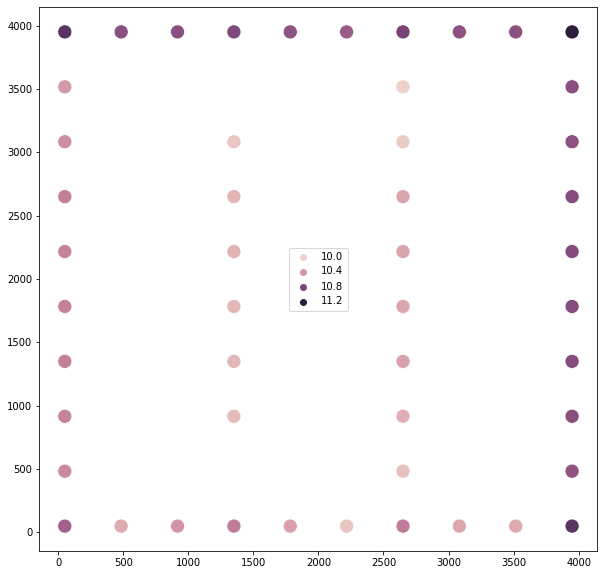

In [63]:
aeps = get_objective(coords,1)
plt.figure(figsize=(10,10))
sns.scatterplot(x=coords[:,0],y=coords[:,1],hue=aeps,s=200) 
plt.show()

In [279]:
##Create a new grid
import copy
from tqdm import tqdm
X = np.linspace(50,3950,100)
fine_coords = []
for x in X:
    for y in X:
        fine_coords.append([x,y])
fine_coords = np.array(fine_coords)
new_coords = coords.copy()
for coord in tqdm(fine_coords):
    temp_coords = new_coords.copy()
    temp_coords = np.vstack((temp_coords,coord))
    if checkConstraints(temp_coords,100)==0:
        new_coords = temp_coords

100%|██████████| 10000/10000 [16:24<00:00, 10.16it/s]


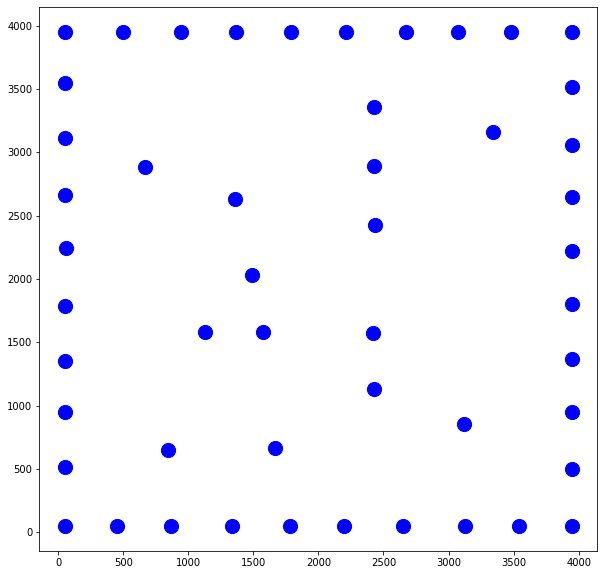

In [6]:
plot_turbines(coords)

In [25]:
new_coords.shape

(97, 2)

In [288]:
new_coords_df = pd.DataFrame(new_coords,columns=['x','y'])
new_coords_df.to_csv('new_coords.csv',index=False)

In [26]:
ls = LSHADE(300,97,new_coords,50,30000,4,0)

In [9]:
ls.run()

516.0415
521.3207
521.5147
521.5147
521.5147
521.5147
522.2318
522.2318
522.2318
522.2318
522.2318
522.2318
522.2318
522.2318
523.1176
523.1176
523.1176
523.1176
523.3277
523.5330
523.5330
523.5330
523.5330
524.0952
524.0952
524.9168
524.9168
525.0425
525.3461
525.3461
525.3461
525.3461
526.1993
526.1993
526.1993
526.1993
527.0921
527.0921
527.0921
527.0921
527.0921
527.0921
527.6863
527.6863
527.6863
528.7338
528.7338
528.7338
528.7338
528.7338
528.7338
528.7338
528.7338
528.8357
528.8357
528.8357
529.3588
529.3588
529.6742
529.6742
529.6742
529.6742
529.6742
529.8277
530.0426
530.0426
530.0426
530.0426
530.0426
530.0426
530.1131
530.1131
530.1697
530.1758
530.1758
530.1758
530.2918
530.3618
530.7875
530.7875
530.7875
530.7875
530.7875
530.7875
530.7875
530.7875
530.7875
530.7875
530.7875
530.7875
530.7875
530.7875
530.7875
530.7875
530.7875
530.7875
530.7875
530.7875
530.7875
530.7875
530.7875
530.7875
530.7875
530.7875
530.7875
530.7875
530.7875
530.7875
530.7875
530.7875
530.7875
5

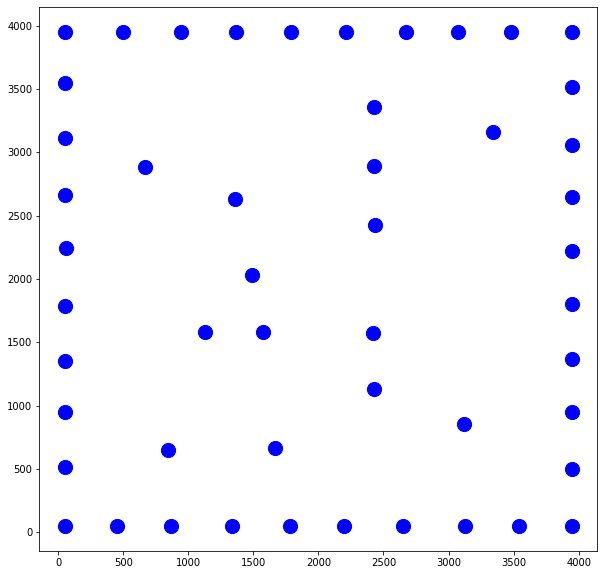

In [10]:
plot_turbines(ls.best_coords)